## Debate Transcripts 

Links:

[CPD Commission of Presidential Debates](https://www.debates.org/voter-education/debate-transcripts/)  
[Topic Modeling with Gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [1]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
import pandas as pd
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style = "fivethirtyeight"
import json
import numpy as np
from os import listdir
import pymongo

import re
import itertools
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.tokenize import word_tokenize
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import pickle


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Transcripts files: Presidential Debates 1960-2016

In [ ]:
filenames = list(listdir('raw_transcripts'))

In [ ]:
filenames

In [ ]:
filenames.pop(0)

In [ ]:
date_str = ['1984-10-11-', '1992-10-11-', '2000-10-11-', '2012-10-11-', '1960-10-13-', '1988-10-13-', 
            '1992-10-13-', '2004-10-13-', '1992-10-15-', '2008-10-15-', '1996-10-16-', '2012-10-16-',
            '2000-10-17-', '1992-10-19-', '2016-10-19-', '2008-10-02-', '1960-10-21-', '1984-10-21-',
            '1976-10-22-', '2012-10-22-', '1980-10-28-', '2000-10-03-', '2012-10-03-', '1988-10-05-',
            '2000-10-05-', '2004-10-05-', '1976-10-06-', '1996-10-06-', '1960-10-07-', '1984-10-07-', 
            '2008-10-07-', '2004-10-08-', '1996-10-09-', '2016-10-09-', '2016-10-04-', '1980-09-21-',
            '1976-09-23-', '1988-09-25-', '1960-09-26-', '2008-09-26-', '2004-09-30-', '2016-09-26-']
len(set(date_str))

### September 26, 2016
Presidential Debate at Hofstra University in Hempstead, New York
- Moderator(s): HOLT

Participants:

+ Democrat: CLINTON
+ Republican: TRUMP

In [ ]:
# Test Debate September 26, 2016
f = open('raw_transcripts/September_26_2016-The First_Clinton-Trump_Presidential_Debate.txt', "r")
raw_transcript = f.read()
# Removes [applause] and non-speaking notes
speaker_transcript = re.sub(r'\[\S+\]', '', raw_transcript)
# Splits the text into lines by each speaker
test_strs = test_strings(parties[0])
pattern = re.compile(test_strs + '(.*)')
lines = pattern.finditer(raw_transcript)
lines_transcript = []
for idx, line in enumerate(lines):
    speaker=''
    if line.group(1) in parties[1]:
        speaker='Democrat'
    elif line.group(1) in parties[2]:
        speaker='Republican'
    elif line.group(1) in parties[3]:
        speaker='Independent'
    elif line.group(1) in parties[4]:
        speaker='Moderator'
    lines_transcript.append({'line_num': date_str[-8] + str(idx), 'speaker': speaker, 
                             'name': line.group(1), 'line': line.group(2)})
lines_transcript

In [ ]:
# Retrieve the speakers from each raw_transcript
speakers = []
for filename in filenames:
    path = 'raw_transcripts/'+str(filename)
    f = open(path, "r")
    speaker_pattern = re.compile(r'(MR\.|MS\.|MRS.)?[A-Zc ]+: ')
    matches = speaker_pattern.finditer(f.read())
    for match in matches:
        speakers.append(match.group())
    
speakers = list(set(speakers))
len(speakers)

In [ ]:
speakers

In [ ]:
# clean speakers
prefixes = (' ')
speakers = [x.lstrip() for x in speakers ]
speakers.remove('PARTICIPANTS: ')
speakers.remove('MODERATORS: ')
speakers

In [ ]:
len(speakers)

In [ ]:
# Categorize everyone!
democrats, republicans, independents = [], [], []
dem_candidates = ['CLINTON', 'KAINE', 'OBAMA', 'BIDEN', 'KERRY', 'EDWARDS', 'GORE', 'LIEBERMAN', 'DUKAKIS',
                  'BENTSEN', 'MONDALE', 'FERRARO', 'CARTER', 'KENNEDY', 'JOHNSON']
rep_candidates = ['TRUMP', 'PENCE', 'ROMNEY', 'RYAN', 'MCCAIN', 'PALIN', 'BUSH', 'CHENEY', 'DOLE', 'KEMP', 
                  'QUAYLE', 'REAGAN', 'FORD', 'DOLE', 'NIXON']
ind_candidates = ['PEROT', 'STOCKDALE']

moderators = speakers.copy()
for dem in dem_candidates:
    for speaker_d in moderators:
        if dem in speaker_d:
            democrats.append(speaker_d)
            moderators.remove(speaker_d)
democrats = list(set(democrats))
for rep in rep_candidates:
    for speaker_r in moderators:
        if rep in speaker_r:
            republicans.append(speaker_r)
            moderators.remove(speaker_r)
republicans = list(set(republicans))            
for ind in ind_candidates:
    for speaker_i in moderators:
        if ind in speaker_i:
            independents.append(speaker_i)
            moderators.remove(speaker_i)
independents = list(set(independents))

parties = [speakers, democrats, republicans, independents, moderators]

In [ ]:
moderators.remove('THE PRESIDENT: ')
republicans.append('THE PRESIDENT: ')
republicans.remove('OXFORD MISSISSIPPI  SPEAKERS: ')
moderators.append('OXFORD MISSISSIPPI  SPEAKERS: ')

In [ ]:
# A function to create regex search strings for 
def test_strings(party): 
    test_str = '('
    for member in party[:-1]:
        test_str = test_str + member + '|'
    test_str = test_str + party[-1] + ')'
    return test_str

In [ ]:
parties

In [ ]:
test_strings(parties[2])

In [ ]:
def clean_and_collect(file, date_string, parties, debates_corpus):
    try:
        # open the file
        path = 'raw_transcripts/'+str(file)
        f = open(path, "r")
        raw_transcript = f.read()
        # Removes [applause] and non-speaking notes
        raw_transcript = re.sub(r'\[\S+\]', '', raw_transcript)
        raw_transcript = re.sub(r'\(\S+\)', '', raw_transcript)
        # Splits the text into lines by each speaker
        test_strs = test_strings(parties[0])
        pattern = re.compile(test_strs + '(.*)')
        lines = pattern.finditer(raw_transcript)
        for idx, line in enumerate(lines):
            speaker=''
            if line.group(1) in parties[1]:
                speaker='Democrat'
            elif line.group(1) in parties[2]:
                speaker='Republican'
            elif line.group(1) in parties[3]:
                speaker='Independent'
            elif line.group(1) in parties[4]:
                speaker='Moderator'
            debates_corpus.append({'line_num': date_string + str(idx), 'speaker': speaker, 
                                   'name': line.group(1), 'line': line.group(2)})
    except:
        print('Oops somthing went wrong')
        pass
    else:
        return debates_corpus

In [ ]:
# Creating the debate corpus for all debates from 1960 
debates_corpus = []
with tqdm(total=len(filenames)) as pbar:
    for index, file in enumerate(filenames):
        date_string = date_str[index]
        debates_corpus = clean_and_collect(file, date_string, parties, debates_corpus)
debates_corpus

In [ ]:
len(debates_corpus)

## MongoDB

In [3]:
# Creates a MongoDB Database
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
mydb = myclient['presidential_debates_db']
debates_collection = mydb['debates_collections']
mydb.get_collection_names

Collection(Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True), 'presidential_debates_db'), 'get_collection_names')

In [4]:
# Save our debates into the MongoDB dataframe
# debates_collection.insert_many(debates_corpus)

In [ ]:
query_1 = debates_collection.find({})
for x in query_1[:50]:
    print(x)

In [ ]:
query_2 = debates_collection.find({'line_num': '2016-09-26-230'})
for x in query_2:
    line_test = x['line']
    print(x['line'])


## Spacy NLP

In [4]:
# Import the English language class with nlp object
nlp = spacy.load("en_core_web_md")

In [5]:
# Adds stopwords to spacy's default list of stopwords
stop_list = ['uh', 'oh', '-PRON-', 'Vice', 'President', 'Senator', 'Governor', 'Secretary', 
             'congresswoman', 'congressman', 'Mr', 'Ms', 'Miss',
             'Clintom', 'Kaine', 'Obama', 'Biden', 'Kerry', 'Edwards', 'Gore', 'Lieberman', 'Dukakis',
             'Bentsen', 'Mondale', 'Ferraro', 'Carter', 'Kennedy', 'Johnson', 'Trump', 'Pence', 'Romney', 
             'Ryan', 'McCain', 'Palin', 'Bush', 'Cheney', 'Dole', 'Kemp', 'Quayle', 'Barack', 'Reagan', 'Ford', 
             'Dole', 'Nixon', 'Perot', 'Stockdale', 'Hillary', 'Donald', 'John', 'George', 'Bob']
for word in stop_list:
    nlp.Defaults.stop_words.add(word)
    nlp.vocab[word].is_stop = True

In [6]:
def lemmatizer(doc):
    doc = [token.lemma_ for token in doc if (token.is_alpha or token.like_num)]
    doc = u' '.join(doc)
    return nlp.make_doc(doc)

In [7]:
# Converts doc to text
def to_text(doc):
    return [token.text for token in doc if not token.is_stop]
#     return u" ".join([token.text for token in doc if not token.is_stop])

In [8]:
def part_of_speech_table(doc):
    for token in doc:
        print(f"{token.text:{10}} {token.pos_:{10:}} {spacy.explain(token)}")

In [9]:
nlp.add_pipe(lemmatizer, after='ner')
nlp.add_pipe(to_text, last=True)
print(nlp.pipe_names)

['tagger', 'parser', 'ner', 'lemmatizer', 'to_text']


In [10]:
nlp.vocab['Nixon'].is_stop

True

In [ ]:
# Call the corpus from database
query_candidates = debates_collection.find( { "$or": [ { "speaker": "Democrat" }, { "speaker": "Republican" } ] } )
candidate_df = pd.DataFrame(list(query_candidates))
candidate_df["party"]= candidate_df["speaker"].apply(lambda y: 0 if y=="Republican" else 1)

In [ ]:
candidate_df.head()

In [ ]:
candidate_df.line.isna().sum()

In [ ]:
candidate_df['docs'].describe()

In [ ]:
raw_lines = candidate_df["line"].tolist()

In [ ]:
raw_lines

In [ ]:
docs = list(nlp.pipe(raw_lines))
docs

In [ ]:
type(docs[0])

In [ ]:
candidate_df["docs"] = docs

## Baseline Modelling

In [ ]:
# Splits the data into a training and testing set
X = candidate_df['docs']
y = candidate_df['party']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=120)

In [ ]:
log_clf = Pipeline([('tfidf', TfidfVectorizer()), ('log', LogisticRegressionCV())])

In [ ]:
log_clf.fit(X_train, y_train)

In [ ]:
y_pred_log = log_clf.predict(X_test)

In [ ]:
baseline = accuracy_score(y_test, y_pred_log)
print('Baseline Accuracy score: ', accuracy_score(y_test, y_pred_log))
print('Baseline Scores: ')
print(classification_report(y_test, y_pred_log))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
classes = ['Republican', 'Democrat']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Logistic Regression',
                          cmap=plt.cm.Blues)

In [ ]:
# Saving: Pickling the model
with open('basemodel.pickle', 'wb') as f:
    pickle.dump(log_clf, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Loading Pickle
with open('basemodel.pickle', 'rb') as file:
    log_clf = pickle.load(file)

In [ ]:
## Other Regression Models

In [ ]:
# K Nearest Neighbors
pipe_knn = Pipeline([('tfidf', TfidfVectorizer()), ('knn', KNeighborsClassifier())])
#use gridsearch to test all values for n_neighbors
param_grid_knn = {'knn__n_neighbors': list(range(5, 26, 2)), 'knn__n_jobs':[-1]}

gs_knn = GridSearchCV(estimator=pipe_knn,
            param_grid=param_grid_knn,
            scoring='accuracy',
            cv=9, return_train_score = True)

gs_knn.fit(X_train, y_train)
# Best params
print('Best params: ', gs_knn.best_params_)

In [ ]:
y_pred_knn = gs_knn.predict(X_test)
print('Best accuracy: ', gs_knn.best_score_)
cm = confusion_matrix(y_test, y_pred_knn)
classes = ['Republican', 'Democrat']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='K Nearest Neighbors',
                          cmap=plt.cm.Blues)

In [ ]:
pipe_rf = Pipeline([('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())])

# Set grid search params
param_grid_forest = [ 
  {'rf__n_estimators': [120],
   'rf__criterion': ['entropy', 'gini'], 
   'rf__max_depth': [4, 5, 6],  
   'rf__min_samples_leaf':[4,8,12],  
   'rf__min_samples_split':[4,8,12],
   'rf__n_jobs':[-1]
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest,
            scoring='accuracy',
            cv=5, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

# Best params
print('Best params: ', gs_rf.best_params_)

In [ ]:
y_pred_rf = gs_rf.predict(X_test)
print('Best accuracy: ', gs_rf.best_score_)
cm = confusion_matrix(y_test, y_pred_rf)
classes = ['Republican', 'Democrat']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Random Forest',
                          cmap=plt.cm.Blues)

## Gensim Topic Modelling

In [27]:
# # Tokenizing 
# def sent_to_words(sentence):
#     yield [word_tokenize(w) for w in sentence]

In [11]:
# N-gram preprocessing
def n_gram_models(texts):
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) 
#     trigram = gensim.models.Phrases(bigram[texts], threshold=500)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
#     trigram_mod = gensim.models.phrases.Phraser(trigram)
    return bigram_mod

In [12]:
# Build the bigram and trigram models
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[doc] for doc in texts]


In [13]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Percent_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [14]:
query_all = debates_collection.find({})
topic_df = pd.DataFrame(list(query_all))

In [15]:
raw_lines = topic_df["line"].tolist()

In [16]:
docs = list(nlp.pipe(raw_lines))
type(docs[0])

list

In [17]:
bigram_mod = n_gram_models(docs)

In [18]:
docs_bigram = make_bigrams(docs)

In [19]:
docs_bigram

[['good',
  'evening',
  'Civic',
  'Center',
  'Philadelphia',
  'Pennsylvania',
  'Dorothy',
  'Ridings',
  'president',
  'League_Women',
  'Voters',
  'sponsor',
  'tonight',
  'vice_presidential',
  'debate',
  'Republican',
  'Democrat',
  'Geraldine',
  'panelist',
  'tonight',
  'debate',
  'Mashek',
  'correspondent',
  'News',
  'World',
  'Report',
  'Jack',
  'White',
  'correspondent',
  'Time',
  'magazine',
  'Norma',
  'Quarles',
  'correspondent',
  'NBC_News',
  'Robert',
  'Boyd',
  'Washington',
  'bureau',
  'chief',
  'Knight',
  'Ridder',
  'Newspapers',
  'Sander',
  'Vanocur',
  'senior',
  'political',
  'correspondent',
  'ABC_News',
  'moderator',
  'tonight',
  'Sandy'],
 ['thank',
  'Dorothy',
  'word',
  'order',
  'format',
  'tonight',
  'order',
  'questioning',
  'determine',
  'toss_coin',
  'Congresswoman',
  'win',
  'toss',
  'elect',
  'speak',
  'question',
  'debate',
  'build',
  'series',
  'question',
  'reporter',
  'panel',
  'reporter',
 

In [20]:
topic_df["docs"] = docs_bigram

In [21]:
topic_df

,_id,line,line_num,name,speaker,docs
0,5d38c31bf997b1856fe64673,"Good evening from the Civic Center in Philadelphia, Pennsylvania. I’m Dorothy Ridings, president of the League of Women Voters, the sponsor of tonight’s vice-presidential debate between Republican George Bush and Democrat Geraldine Ferraro. Our panelists for tonight’s debate are John Mashek, correspondent for U.S. News & World Report; Jack White, correspondent for Time magazine; Norma Quarles, correspondent for NBC News; and Robert Boyd, Washington bureau chief for Knight-Ridder Newspapers. Sander Vanocur, senior political correspondent for ABC News, is our moderator tonight. Sandy.",1984-10-11-0,RIDINGS:,Moderator,"[good, evening, Civic, Center, Philadelphia, Pennsylvania, Dorothy, Ridings, president, League_Women, Voters, sponsor, tonight, vice_presidential, debate, Republican, Democrat, Geraldine, panelist, tonight, debate, Mashek, correspondent, News, World, Report, Jack, White, correspondent, Time, magazine, Norma, Quarles, correspondent, NBC_News, Robert, Boyd, Washington, bureau, chief, Knight, Ridder, Newspapers, Sander, Vanocur, senior, political, correspondent, ABC_News, moderator, tonight, Sandy]"
1,5d38c31bf997b1856fe64674,"Thank you, Dorothy. A few words about the order of our format tonight. The order of questioning was determined by a toss of the coin. Congresswoman Ferraro won the toss. She elected to speak last. Therefore Vice President Bush will get the first question. The debate will be built upon a series of questions from the four reporters on the panel. A reporter will ask a candidate a question, a follow-up question and then the same to the other candidate; then each candidate will get to rebut the other. The debate will be divided into two parts. There’ll be a section, the first: one, on domestic affairs; the second on foreign affairs. Now the manner of address was decided by the candidates. Therefore it will be Vice President Bush, Congresswoman Ferraro. And we begin our questioning with Mr. Mashek.",1984-10-11-1,VANOCUR:,Moderator,"[thank, Dorothy, word, order, format, tonight, order, questioning, determine, toss_coin, Congresswoman, win, toss, elect, speak, question, debate, build, series, question, reporter, panel, reporter, ask, candidate, question, follow, question, candidate, candidate, rebut, debate, divide, section, domestic, affair, second, foreign_affair, manner, address, decide, candidate, Congresswoman, begin, questioning, Mashek]"
2,5d38c31bf997b1856fe64675,"John Adams, our nation’s first vice-president, once said: “Today I am nothing. Tomorrow I may be everything.” With that in mind, I’d like to ask the following question: Vice President Bush, four years ago, you ran against Mr. Reagan for the Republican nomination. You disagreed with him on such issues as the Equal Rights Amendment, abortion, and you labeled his economic policies as voodoo. Now you apparently agree with him on every issue. If you should be called upon to assume the presidency, would you follow Mr. Reagan’s policies down the line or would you revert to some of your own ideas.",1984-10-11-2,MASHEK:,Moderator,"[Adams, nation, vice, president, today, tomorrow, mind, like, ask, following, question, year, ago, run, republican, nomination, disagree, issue, Equal, Rights, Amendment, abortion, label, economic, policy, voodoo, apparently, agree, issue, assume, presidency, follow, policy, line, revert, idea]"
3,5d38c31bf997b1856fe64676,"Well, I don’t think there’s a great difference, Mr. Mashek, between my views and President Reagan’s. One of the reasons I think we’re an effective team is that I believe firmly in his leadership. He’s really turned this country around. We agree on the economic program. When we came into office, why, inflation was 21, 12 1/2 percent interest was wiping out every single American were 21 1/2 percent if you can believe it. Productivity was down. Savings was down. There was despair. In fact, the leadership of the country told the people tha

In [22]:
topic_df = topic_df.drop(topic_df[(topic_df["docs"].str.len()==0)].index)
topic_df.reset_index(inplace=True)
topic_df.drop('index', axis=1, inplace=True)
topic_df.shape

(6785, 6)

In [23]:
topic_docs = topic_df['docs'].tolist()

In [24]:
id2word = corpora.Dictionary(topic_docs)
corpus = [id2word.doc2bow(doc) for doc in topic_docs]

In [75]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=1968,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [76]:
# Label lines with their dominant topic
df_topic_sents_keywords = format_topics_sentences(lda_model, corpus=corpus, texts=topic_docs)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.shape

(6785, 5)

In [77]:
topic_model_df = pd.concat([topic_df, df_dominant_topic], axis=1)
topic_model_df = topic_model_df.drop(['_id', 'Text', 'Document_No'], axis=1)
topic_model_df.head()

,line,line_num,name,speaker,docs,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,"Good evening from the Civic Center in Philadelphia, Pennsylvania. I’m Dorothy Ridings, president of the League of Women Voters, the sponsor of tonight’s vice-presidential debate between Republican George Bush and Democrat Geraldine Ferraro. Our panelists for tonight’s debate are John Mashek, correspondent for U.S. News & World Report; Jack White, correspondent for Time magazine; Norma Quarles, correspondent for NBC News; and Robert Boyd, Washington bureau chief for Knight-Ridder Newspapers. Sander Vanocur, senior political correspondent for ABC News, is our moderator tonight. Sandy.",1984-10-11-0,RIDINGS:,Moderator,"[good, evening, Civic, Center, Philadelphia, Pennsylvania, Dorothy, Ridings, president, League_Women, Voters, sponsor, tonight, vice_presidential, debate, Republican, Democrat, Geraldine, panelist, tonight, debate, Mashek, correspondent, News, World, Report, Jack, White, correspondent, Time, magazine, Norma, Quarles, correspondent, NBC_News, Robert, Boyd, Washington, bureau, chief, Knight, Ridder, Newspapers, Sander, Vanocur, senior, political, correspondent, ABC_News, moderator, tonight, Sandy]",2.0,0.7028,"question, minute, Clinton, thank, ask, tonight, debate, candidate, attack, second"
1,"Thank you, Dorothy. A few words about the order of our format tonight. The order of questioning was determined by a toss of the coin. Congresswoman Ferraro won the toss. She elected to speak last. Therefore Vice President Bush will get the first question. The debate will be built upon a series of questions from the four reporters on the panel. A reporter will ask a candidate a question, a follow-up question and then the same to the other candidate; then each candidate will get to rebut the other. The debate will be divided into two parts. There’ll be a section, the first: one, on domestic affairs; the second on foreign affairs. Now the manner of address was decided by the candidates. Therefore it will be Vice President Bush, Congresswoman Ferraro. And we begin our questioning with Mr. Mashek.",1984-10-11-1,VANOCUR:,Moderator,"[thank, Dorothy, word, order, format, tonight, order, questioning, determine, toss_coin, Congresswoman, win, toss, elect, speak, question, debate, build, series, question, reporter, panel, reporter, ask, candidate, question, follow, question, candidate, candidate, rebut, debate, divide, section, domestic, affair, second, foreign_affair, manner, address, decide, candidate, Congresswoman, begin, questioning, Mashek]",2.0,0.5173,"question, minute, Clinton, thank, ask, tonight, debate, candidate, attack, second"
2,"John Adams, our nation’s first vice-president, once said: “Today I am nothing. Tomorrow I may be everything.” With that in mind, I’d like to ask the following question: Vice President Bush, four years ago, you ran against Mr. Reagan for the Republican nomination. You disagreed with him on such issues as the Equal Rights Amendment, abortion, and you labeled his economic policies as voodoo. Now you apparently agree with him on every issue. If you should be called upon to assume the presidency, would you follow Mr. Reagan’s policies down the line or would you revert to some of your own ideas.",1984-10-11-2,MASHEK:,Moderator,"[Adams, nation, vice, president, today, tomorrow, mind, like, ask, following, question, year, ago, run, republican, nomination, disagree, issue, Equal, Rights, Amendment, abortion, label, economic, policy, voodoo, apparently, agree, issue, assume, presidency, follow, policy, line, revert, idea]",9.0,0.1514,"think, right, talk, let, president, United_States, use, time, support, mean"
3,"Well, I don’t think there’s a great difference, Mr. Mashek, between my views and President Reagan’s. One of the reasons I think we’re an effective team is that I believe firmly in his leadership. He’s really turned this country around. We agree on the economic program. When we came into office, why, inflation was 21, 12 1

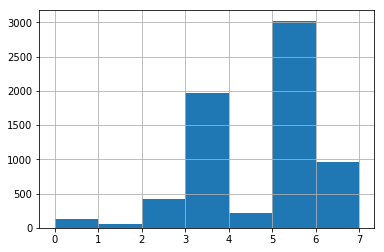

In [140]:
topic_model_df['Dominant_Topic'].hist(bins=7, range=(0,7))

In [145]:
candidate_model_df = topic_model_df.drop(['line_num', 'docs', 'Topic_Perc_Contrib', 'Keywords'], axis=1)
candidate_model_df = candidate_model_df[candidate_model_df['speaker']!='Moderator']

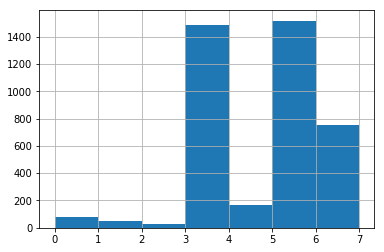

In [146]:
candidate_model_df['Dominant_Topic'].hist(bins=7, range=(0,7))

In [147]:
candidate_model_df.head()

,line,name,speaker,Dominant_Topic,Topics
3,"Well, I don’t think there’s a great difference, Mr. Mashek, between my views and President Reagan’s. One of the reasons I think we’re an effective team is that I believe firmly in his leadership. He’s really turned this country around. We agree on the economic program. When we came into office, why, inflation was 21, 12 1/2 percent interest was wiping out every single American were 21 1/2 percent if you can believe it. Productivity was down. Savings was down. There was despair. In fact, the leadership of the country told the people that there was a malaise out there. And this president turned it around and I’ve been with him every step of the way. And of course I would continue those kinds of programs because it’s brought America back. America’s better off. People are going back to work. And why Mr. Monad can’t understand that there’s a new enthusiasm in this country, that America is back, there’s new strong leadership, I don’t know. He has one answer to the problem. Raise everybody’s taxes. He looked right into that lens and he said out there in San Francisco, he said, “I’m gonna raise your taxes.” Well he’s had a lot of experience in that and he’s sure gonna go ahead and do it. But I remember a statement of Lyndon Johnson’s when he was looking around, why his party people weren’t supporting him, and he said, “Hey, they painted their tails white and they ran with the antelopes.” There’s a lot of Democratic white tails running with the antelopes. Not one single Democrat has introduced the Mondale tax bill into the Congress. Of course I support the president’s economic program and I support him in everything else. And I’m not sure, because of my concept of the vice presidency, that if I didn’t, I’d go doing what Mr. Mondale has done with Jimmy Carter; jump away from him. I couldn’t do that to Ronald Reagan, now, next year or any other time. I have too much trust in him. I have too much friendship for him. And I’d feel very uncomfortable doing that.",BUSH:,Republican,5,Foreign Policy
5,"I owe my president my judgment and then I owe him loyalty. You can’t have the president of the United States out there looking over his shoulder wondering whether his vice president is going to be supporting him. Mrs. Ferraro has quite a few differences with Vice-President Mondale and I understood it when she changed her position on tuition tax credits. They’re different on busing; she voted to extend the grain embargo; he now says that he was against it. If they win – and I hope they don’t – but if they win, she’ll have to accommodate some views. But she’ll give him the same kind of loyalty that I’m giving President Reagan. One, we’re not far apart on anything. Two, I can walk into that Oval Office anytime and give him my judgment and he might agree or he might not. But he also knows I won’t be talking about it to the press or I won’t be knifing him in the back by leaking to make me look good and complicate the problems of the president of the United States.",BUSH:,Republican,5,Foreign Policy
7,"Well, let me first say that I wasn’t born at the age of forty-three when I entered Congress. I did have a life before that as well. I was a prosecutor for almost five years in the district attorney’s office in Queens County and I was a teacher. There’s not only what is on your paper resume that makes you qualified to run for or to hold office. It’s how you approach problems and what your values are. I think if one is taking a look at my career they’ll see that I level with the people; that I approach problems analytically; that I am able to assess the various facts with reference to a problem, and I can make the hard decisions. I’m intrigued when I hear Vice-President Bush talk about his support of the president’s economic program and how everything is just going so beautifully. I, too, recall when Vice President Bush was running in the primary against President Reagan and he called the program voodoo economics

In [81]:
# Print the Keyword in the topics
pprint(lda_model.print_topics(num_words=50))
doc_lda = lda_model[corpus]

[(0,
  '0.044*"issue" + 0.031*"vote" + 0.024*"think" + 0.021*"campaign" + '
  '0.021*"judgment" + 0.020*"decision" + 0.019*"win" + 0.018*"record" + '
  '0.016*"run" + 0.016*"begin" + 0.015*"people" + 0.014*"word" + '
  '0.014*"defeat" + 0.014*"person" + 0.013*"speak" + 0.012*"state" + '
  '0.012*"party" + 0.011*"lead" + 0.011*"republican" + 0.010*"turn" + '
  '0.009*"quickly" + 0.008*"kind" + 0.008*"House" + 0.007*"trade" + '
  '0.007*"reach" + 0.007*"regard" + 0.007*"personal" + 0.007*"political" + '
  '0.006*"tell" + 0.006*"pick" + 0.006*"summit" + 0.006*"check" + 0.006*"feel" '
  '+ 0.006*"position" + 0.006*"environment" + 0.006*"Washington" + '
  '0.006*"employee" + 0.006*"race" + 0.005*"Government" + 0.005*"accept" + '
  '0.005*"elect" + 0.005*"recognize" + 0.005*"liberal" + 0.005*"presidency" + '
  '0.005*"hope" + 0.005*"read" + 0.005*"Democrats" + 0.005*"politician" + '
  '0.004*"notion" + 0.004*"provide"'),
 (1,
  '0.029*"home" + 0.024*"respond" + 0.018*"future" + 0.017*"half" 

In [123]:
candidate_model_df[['name','line']][candidate_model_df['Dominant_Topic']==2.0]

,name,line
550,RYAN:,"Joe and I are from similar towns. He’s from Scranton, Pennsylvania. I’m from Janesville, Wisconsin. You know what the unemployment rate in Scranton is today?"
869,MR. KENNEDY:,"Good evening, Mr. Shadel."
871,MR. NIXON:,"Good evening, Mr. Shadel."
1131,GORE:,"Well, you’ve asked me the question. If you won’t answer my question I will answer yours."
1191,GORE:,"He also said he wanted to be the environmental president; then he went on to say he wanted to be the education president. Then he said that he wouldn’t raise taxes again — no, never, ever, ever. Then the next day his spokesman, Marlin Fitzwater, came out and said that’s not a pledge. Then 2 weeks ago he said that after the election, if you win, then James Baker’s going to go back to be secretary of state; then a week later, in the debate a few nights ago, he said, no, after the election, if we win, James Baker is going to be in charge of domestic policy. Which is it, Dan? Is he going to — what’s your role in this going to be? (Laughter and applause)"
1387,QUAYLE:,"Hal, you said — and I wrote it down here — “personal negative attacks.” Has anyone been reading my press clippings for the last 4 years? But I happen to — I agree with one thing on — with Senator Gore, and that is that we ought to look to the future, and the future is, who’s going to be the next president of the US. And is it a negative attack and a personal attack to point out that Bill Clinton simply has trouble telling the truth? He said that he didn’t even demonstrate — he told the people in Arkansas in 1978. Then we find out he organized demonstrations. You know, I don’t care whether he demonstrated or didn’t demonstrate. The fact — the question is, tell the truth. Just tell us the truth. Today, Bill Clinton — excuse me — yesterday in Philadelphia on a radio show, just yesterday on a radio show, he attacked — Admiral, he attacks Ross Perot saying the media is giving Ross Perot a free ride. The press asked him when the klieg lights are on, said what do you mean by Ross Perot getting a free ride? He says I didn’t say that at all. I mean, you can’t have it both ways. No, I don’t think that is a personal attack. What I find troubling with Bill Clinton is he can’t tell the truth. You cannot lead this great country of ours by misleading the people."
1700,BUSH:,May I ask for an exception because I think we owe Carole Simpson — anybody who can stand in between these three characters here and get the job done — we owe her a round of applause. But don’t take it out of my time!
1709,PEROT:,But it’s in your hands. I wish you well. I’ll see you tomorrow night — on NBC — 10:30 to 11:00 Eastern Time.
1885,CLINTON:,May I ask you a question? What service are you in?
2001,ROMNEY:,"Thank you, Jeremy. I appreciate your — your question, and thank you for being here this evening and to all of those from Nassau County that have come, thank you for your time. Thank you to Hofstra University and to Candy Crowley for organizing and leading this — this event. Thank you, Mr. President, also for being part of this — this debate. Your question — your question is one that’s being asked by college kids all over this country. I was in Pennsylvania with someone who had just graduated — this was in Philadelphia — and she said, “I’ve got my degree. I can’t find a job. I’ve got three part- time jobs. They’re just barely enough to pay for my food and pay for an apartment. I can’t begin to pay back my student loans.” So what we have to do is two things. We have to make sure that we make it easier for kids to afford college."


In [134]:
(topic_model_df['Dominant_Topic']==6).value_counts()

False    5828
True     957 
Name: Dominant_Topic, dtype: int64

In [115]:
# Saving: Pickling the model
with open('lda_model.pickle', 'wb') as f:
    pickle.dump(lda_model, f, pickle.HIGHEST_PROTOCOL)

In [116]:
# Loading Pickle
with open('lda_model.pickle', 'rb') as file:
    lda_model = pickle.load(file)

In [128]:
topic_remap = {0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5, 6.0: 1, 7.0: 0, 8.0: 4, 9.0: 5, 10.0: 5, 11.0: 6}

In [130]:
topic_model_df['Dominant_Topic'] = topic_model_df['Dominant_Topic'].map(topic_remap)

In [143]:
topic_categories = {0: 'Court Cases', 1: 'Global Warming', 2: 'Thanks', 3: 'Taxes/Economy', 
                    4: 'Abortion/Drugs/Race/Guns', 5: 'Foreign Policy', 6: 'Military'}

In [144]:
topic_model_df['Topics'] = topic_model_df['Dominant_Topic'].map(topic_categories)

In [ ]:
plt.pie(candidate_model_df['Topics'].hist())